In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from scipy import stats
from pathlib import Path, PureWindowsPath

In [2]:
def extract_dataset_info(data_path):
    # extract information from train.txt
    f = open(os.path.join(data_path, "train.txt"), "r")
    contents_train = f.readlines()
    label_classes, label_train_list, img_train_list = [], [], []
    for sample in contents_train:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        if label not in label_classes:
            label_classes.append(label)
        label_train_list.append(sample[0])
        img_train_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))
    print('Classes: {}'.format(label_classes))

    # extract information from test.txt
    f = open(os.path.join(data_path, "test.txt"), "r")
    contents_test = f.readlines()
    label_test_list, img_test_list = [], []
    for sample in contents_test:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        label_test_list.append(label)
        img_test_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))  # you can directly use img_path if you run in Windows

    return label_classes, label_train_list, img_train_list, label_test_list, img_test_list

In [46]:
def compute_dsift(img):
    # To do
    # Create a sift object.
    sift = cv2.SIFT_create()

    # Stride and Size.
    stride = 8
    size = 8

    # # Get the Center points in the image patches, this gives the Locations which are Keypoints.
    # u = [i for i in range(0, img.shape[1]-size+1,stride)]   # Plus one was done to consider the last line
    # v = [i for i in range(0, img.shape[0]-size+1, stride)]
    # X, Y = np.meshgrid(u,v)
    # X = (X.ravel() + size//2).astype(float)
    # Y = (Y.ravel() + size//2).astype(float)

    # # Make Keypoints where you want to calculate the Descriptor.
    # keypoints = [cv2.KeyPoint(x, y, size) for (x, y) in zip(X , Y)]

    X = (np.arange(0, img.shape[1] - size + 1, stride, dtype=np.float16) + size//2)
    Y = np.arange(0, img.shape[0] - size + 1, stride, dtype=np.float16) + size//2
    keypoints = [cv2.KeyPoint(x, y, size) for x in X for y in Y]

    # Make the descriptors for all the keypoints locations.
    keypoints, dense_feature = sift.compute(img, keypoints)

    return dense_feature

img = cv2.imread("image_0043.jpg",0)
dense_features = compute_dsift(img)
print(dense_features.shape)

(1024, 128)


In [6]:
def get_tiny_image(img, output_size):
    # To do
    feature = cv2.resize(img,output_size)

    # Normalize the Image.
    feature = feature - np.mean(feature)
    feature = feature/ np.linalg.norm(feature)

    return feature

In [15]:
def predict_knn(feature_train, label_train, feature_test, k):
    # To do

    ## Initialize KNN
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(feature_train, label_train)

    # Make predictions.
    label_test_pred = neigh.predict(feature_test)
    
    return label_test_pred

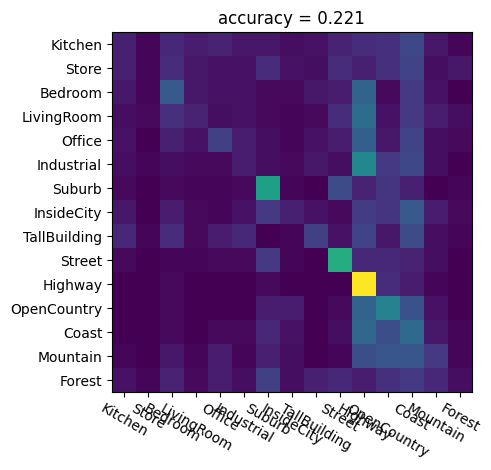

(array([[0.07, 0.01, 0.09, 0.06, 0.08, 0.05, 0.05, 0.03, 0.04, 0.08, 0.1 ,
         0.11, 0.17, 0.05, 0.01],
        [0.07, 0.01, 0.1 , 0.05, 0.04, 0.04, 0.1 , 0.04, 0.03, 0.1 , 0.07,
         0.11, 0.16, 0.03, 0.05],
        [0.05, 0.01, 0.22, 0.05, 0.04, 0.04, 0.02, 0.02, 0.05, 0.06, 0.25,
         0.02, 0.13, 0.04, 0.  ],
        [0.03, 0.02, 0.11, 0.08, 0.03, 0.04, 0.02, 0.01, 0.02, 0.1 , 0.28,
         0.04, 0.13, 0.06, 0.03],
        [0.04, 0.  , 0.07, 0.04, 0.15, 0.06, 0.03, 0.01, 0.04, 0.06, 0.24,
         0.05, 0.16, 0.03, 0.02],
        [0.03, 0.01, 0.03, 0.02, 0.02, 0.06, 0.03, 0.02, 0.05, 0.03, 0.37,
         0.13, 0.17, 0.03, 0.  ],
        [0.02, 0.  , 0.02, 0.01, 0.01, 0.02, 0.45, 0.01, 0.  , 0.18, 0.08,
         0.12, 0.07, 0.  , 0.01],
        [0.05, 0.  , 0.06, 0.02, 0.01, 0.04, 0.13, 0.07, 0.04, 0.02, 0.14,
         0.12, 0.22, 0.06, 0.02],
        [0.09, 0.01, 0.1 , 0.02, 0.06, 0.09, 0.  , 0.01, 0.15, 0.04, 0.16,
         0.05, 0.18, 0.03, 0.01],
        [0.02, 0.  

In [17]:
def classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do

    output_size = (16,16)

    # Map labels to integers.
    label_map = {key : value+1 for value, key in enumerate(label_classes)}

    # Convert all labels to Integers.
    label_train_int = np.array([label_map[item] for item in label_train_list])
    label_test_int = np.array([label_map[item] for item in label_test_list])
    label_classes_int = np.array([label_map[item] for item in label_classes])

    # Get the tiny image of all the train items.
    feature_train = np.zeros((len(img_train_list), output_size[0]*output_size[1]))
    for i,path_img in enumerate(img_train_list):
        img = cv2.imread(path_img,0) # Read Image, 0 to read as greyscale.
        feature_train[i,:] = get_tiny_image(img, output_size).flatten()   # Get features using tiny image funtion.

    # Get the tiny image of all the test items.
    feature_test = np.zeros((len(img_test_list), output_size[0]*output_size[1]))
    for i,path_img in enumerate(img_test_list):
        img = cv2.imread(path_img,0) # 0 to read as greyscale.
        feature_test[i,:] = get_tiny_image(img, output_size).flatten()
    
    # Predict labels for the test images.
    k_neighbour = 10
    label_test_pred = predict_knn(feature_train, label_test_int, feature_test, k_neighbour)

    # Make the confusion Matrix.
    confusion = np.zeros((len(label_classes), len(label_classes)))
    for row,cls in enumerate(label_classes_int):
        indices = np.where(label_test_int == cls)[0]
        preds_temp = np.array([label_test_pred[i] for i in indices])
        for col in range(len(label_classes)):
            confusion[row,col] = np.sum(preds_temp == label_classes_int[col]) / len(indices)

    # Find the accuracy as mean of the correct predictions.
    accuracy = np.mean(np.diagonal(confusion))

    visualize_confusion_matrix(confusion, accuracy, label_classes)

    return confusion, accuracy

classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

In [47]:
def build_visual_dictionary(dense_feature_list, dict_size):
    # To do

    # For each Image, compute dense SIFT over regular grid.

    # List of features is passed stack them in a matrix.
    train_features = np.vstack(dense_feature_list)
    # train_features = np.empty((0,128))
    # for feature in dense_feature_list:  # Just do vstact of list that we do the same.
    #     train_features = np.vstack((train_features, feature))

    ## Assume that dense_feature_list is list of training images.
    # Get the dense features image of all the train items.
    # dense_features = np.empty((0,128))
    # for i,path_img in enumerate(dense_feature_list):
    #     img = cv2.imread(path_img,0) # Read Image, 0 to read as greyscale.
    #     features = compute_dsift(img)
    #     dense_features = np.vstack((dense_features, features))
        
    # print("Shape and Size of Dense Features : ", dense_features.shape)
    
    # Initialize a kmean object.
    kmeans = KMeans(n_clusters=dict_size, init='random', n_init=10 ,max_iter=100)
    # Fit the data into kmeans.
    kmeans.fit(train_features)

    # Get the Cluster Centers of teh items.
    vocab = kmeans.cluster_centers_

    # Save this vocal to a file.
    np.savetxt('vocab.txt', vocab)

    return vocab

In [43]:
def compute_bow(feature, vocab):
    # To do

    # Initailize a nearest neighbour object.
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(vocab)
    distance, indices = neigh.kneighbors(feature)

    # Count the SIFT features that fall into each cluster of the vocab.
    bow_feature = np.bincount(indices[:,0], minlength=vocab.shape[0])

    # Normalize the bow_features.
    bow_feature = bow_feature / np.linalg.norm(bow_feature)

    return bow_feature

img = cv2.imread("image_0043.jpg",0)
# feature = compute_dsift(img)
# bow_feature = compute_bow(feature, vocab)

In [48]:
def classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do
    
    # Map labels to integers.
    label_map = {key : value+1 for value, key in enumerate(label_classes)}

    # Convert all labels to integers.
    label_train_int = np.array([label_map[item] for item in label_train_list])
    label_test_int = np.array([label_map[item] for item in label_test_list])

    label_classes_int = np.array([label_map[item] for item in label_classes])

    # Get Dense Features for all the training images.
    train_features = []
    for i,path_img in enumerate(img_train_list):
        img = cv2.imread(path_img,0) # Read Image, 0 to read as greyscale.
        feature = compute_dsift(img)
        train_features.append(feature)

    ## Use saved visual dict.
    use_saved_file = False
    if not use_saved_file:
        dict_size = 50
        vocab = build_visual_dictionary(train_features, dict_size)
    else:
        vocab = np.loadtxt('vocab.txt')

    # Build histograms for all the training data. Compute BOW Does that for you.
    histo_train = np.empty((0,vocab.shape[0]))
    for feature in train_features:
        histo = compute_bow(feature, vocab)   ## Compute bow is for every imafe
        histo_train = np.vstack((histo_train, histo))

    ''' Pseudo Algo.
    1. Take patches from all the training images.
    2. Compute sift for all the patches. This is your Pool of sift descriptors.
    3. Cluster these sifts into 50 or so bins. Take the controid of them, This is your dictionary of Centroids.
    4. Now Build histogram for all the training data. 
    5. Cluster these histogram vector into 15 classes.
    6. Find the histogram for the test image.
    7. See its nearest neighbour form 15 classes clustre, this is the label for that image.    
    '''
    # Get Dense Features for all the test images.
    test_features = []
    for i, path_img in enumerate(img_test_list):
        img = cv2.imread(path_img,0)
        feature = compute_dsift(img)
        test_features.append(feature)

    # Build histograms for all the test data. Compute BOW Does that for you.
    histo_test = np.empty((0,vocab.shape[0]))
    for feature in test_features:
        histo = compute_bow(feature, vocab)
        histo_test = np.vstack((histo_test, histo))

    # Predict labels for the test images.
    k_neighbour = 10
    label_test_pred = predict_knn(histo_train, label_test_int, histo_test, k_neighbour)

    # Make the confusion Matrix.
    confusion = np.zeros((len(label_classes), len(label_classes)))
    for row,cls in enumerate(label_classes_int):
        indices = np.where(label_test_int == cls)[0]
        preds_temp = np.array([label_test_pred[i] for i in indices])
        for col in range(len(label_classes)):
            confusion[row,col] = np.sum(preds_temp == label_classes_int[col]) / len(indices)

    # Find the accuracy as mean of the correct predictions.
    accuracy = np.mean(np.diagonal(confusion))

    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

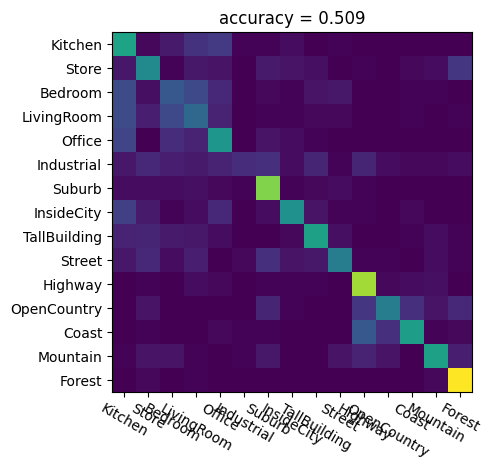

(array([[0.55, 0.02, 0.07, 0.14, 0.16, 0.01, 0.01, 0.03, 0.  , 0.01, 0.  ,
         0.  , 0.  , 0.  , 0.  ],
        [0.06, 0.45, 0.01, 0.06, 0.05, 0.  , 0.07, 0.05, 0.04, 0.  , 0.01,
         0.  , 0.02, 0.03, 0.15],
        [0.22, 0.04, 0.26, 0.21, 0.11, 0.  , 0.02, 0.01, 0.05, 0.06, 0.  ,
         0.  , 0.01, 0.01, 0.  ],
        [0.22, 0.08, 0.21, 0.32, 0.09, 0.  , 0.01, 0.01, 0.02, 0.02, 0.  ,
         0.  , 0.01, 0.  , 0.01],
        [0.2 , 0.  , 0.12, 0.09, 0.5 , 0.  , 0.05, 0.03, 0.01, 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  ],
        [0.06, 0.11, 0.08, 0.07, 0.09, 0.12, 0.13, 0.03, 0.1 , 0.01, 0.1 ,
         0.03, 0.02, 0.02, 0.03],
        [0.03, 0.03, 0.03, 0.04, 0.02, 0.01, 0.77, 0.01, 0.02, 0.03, 0.01,
         0.  , 0.  , 0.  , 0.  ],
        [0.18, 0.07, 0.01, 0.03, 0.11, 0.  , 0.03, 0.48, 0.05, 0.01, 0.01,
         0.  , 0.02, 0.  , 0.  ],
        [0.09, 0.1 , 0.07, 0.06, 0.03, 0.  , 0.  , 0.02, 0.54, 0.04, 0.  ,
         0.  , 0.01, 0.03, 0.01],
        [0.06, 0.11

In [49]:
classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

In [23]:
def predict_svm(feature_train, label_train, feature_test, n_classes):
    # To do
    # Use Support Vector Machine to Classify the data.
    # Make Linear SVC Instance.
    clf = LinearSVC(C=1, dual=True)   # C is regularization parameter are default.

    # Create Binary Labels for all the items.
    # Then do 15 Classification and get the scores select the output from them.
    label_test_binary = np.empty((0,len(feature_test)))
    for i in range(1, n_classes+1):
        # Generate binary label for this class
        label_train_i = (label_train == i).astype(int)
        clf.fit(feature_train, label_train_i)
        label_test_i = clf.decision_function(feature_test)
        label_test_binary = np.vstack((label_test_binary, label_test_i))
    
    # You want the max label not the score
    label_test_pred = np.argmax(label_test_binary, axis=0) + 1

    return label_test_pred


In [28]:
def classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do

    # Map labels to integers.
    label_map = {key : value+1 for value, key in enumerate(label_classes)}
    label_train_int = np.array([label_map[item] for item in label_train_list])
    label_test_int = np.array([label_map[item] for item in label_test_list])

    label_classes_int = np.array([label_map[item] for item in label_classes])


    # Build a visual dictinary.
    # vocab = build_visual_dictionary(img_train_list, 50)

    # Get Histogram for all the training images.
    # train_features = np.empty((0,128))
    train_features = []
    for i,path_img in enumerate(img_train_list):
        img = cv2.imread(path_img,0) # Read Image, 0 to read as greyscale.
        feature = compute_dsift(img)
        train_features.append(feature)
        # train_features = np.vstack((train_features, features))

    dict_size = 50
    vocab = build_visual_dictionary(train_features, dict_size)   # This is some 50 cluster centers.

    # Build histograms for all the training data. Compute BOW Does that for you.
    histo_train = np.empty((0,vocab.shape[0]))
    for feature in train_features:
        histo = compute_bow(feature, vocab)
        histo_train = np.vstack((histo_train, histo))


    ''' Pseudo Algo.
    1. Take patches from all the training images.
    2. Compute sift for all the patches. This is your Pool of sift descriptors.
    3. Cluster these sifts into 50 or so bins. Take the controid of them, This is your dictionary of Centroids.
    4. Now Build histogram for all the training data. 
    5. For Each Class Fit a SVM Model for that class and predicct scores return the final labels accordinly.
    '''

    # This can be done in one step.
    test_features = []
    for i, path_img in enumerate(img_test_list):
        img = cv2.imread(path_img,0)
        feature = compute_dsift(img)
        test_features.append(feature)

    histo_test = np.empty((0,vocab.shape[0]))
    for feature in test_features:
        histo = compute_bow(feature, vocab)
        histo_test = np.vstack((histo_test, histo))

    
    # # Predict labels for the test images.
    # k_neighbour = 1
    # label_test_pred = predict_knn(histo_train, label_test_int, histo_test, k_neighbour)

    n_classes = 15
    label_test_pred = predict_svm(histo_train, label_train_int, histo_test, n_classes)

    print("Label test Pred : ", label_test_pred)

    # Make the confusion Matrix.
    confusion = np.zeros((len(label_classes), len(label_classes)))
    for row,cls in enumerate(label_classes_int):
        indices = np.where(label_test_int == cls)[0]
        preds_temp = np.array([label_test_pred[i] for i in indices])
        for col in range(len(label_classes)):
            confusion[row,col] = np.sum(preds_temp == label_classes_int[col]) / len(indices)

    # Find the accuracy as mean of the correct predictions.
    accuracy = np.mean(np.diagonal(confusion))

    
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

/Users/saturn/miniforge3/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/saturn/miniforge3/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/saturn/miniforge3/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/saturn/miniforge3/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/saturn/mi

Label test Pred :  [ 9  9  1 ... 15 15 15]
Max in confution matrix :  0.93


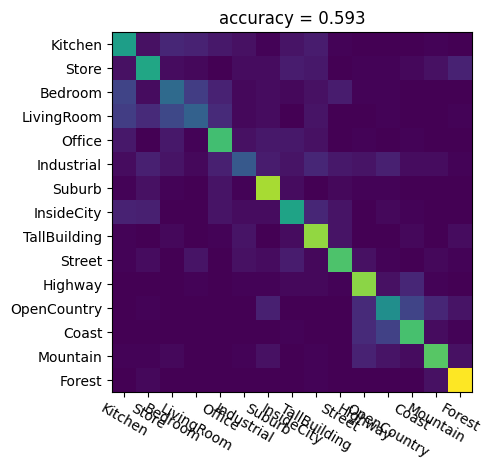

(array([[0.52, 0.04, 0.1 , 0.09, 0.06, 0.04, 0.01, 0.05, 0.07, 0.01, 0.  ,
         0.  , 0.  , 0.01, 0.  ],
        [0.04, 0.55, 0.03, 0.02, 0.  , 0.03, 0.03, 0.07, 0.06, 0.  , 0.01,
         0.01, 0.02, 0.04, 0.09],
        [0.19, 0.03, 0.32, 0.17, 0.09, 0.02, 0.03, 0.02, 0.04, 0.07, 0.01,
         0.01, 0.  , 0.  , 0.  ],
        [0.17, 0.11, 0.2 , 0.29, 0.11, 0.02, 0.03, 0.  , 0.05, 0.  , 0.  ,
         0.01, 0.  , 0.  , 0.01],
        [0.06, 0.  , 0.06, 0.01, 0.65, 0.04, 0.06, 0.06, 0.04, 0.  , 0.01,
         0.  , 0.01, 0.  , 0.  ],
        [0.03, 0.08, 0.05, 0.02, 0.08, 0.26, 0.07, 0.05, 0.1 , 0.06, 0.05,
         0.08, 0.03, 0.03, 0.01],
        [0.01, 0.04, 0.01, 0.  , 0.05, 0.01, 0.81, 0.03, 0.  , 0.02, 0.01,
         0.01, 0.  , 0.  , 0.  ],
        [0.09, 0.08, 0.  , 0.  , 0.05, 0.03, 0.03, 0.54, 0.1 , 0.05, 0.  ,
         0.02, 0.01, 0.  , 0.  ],
        [0.01, 0.  , 0.02, 0.  , 0.01, 0.05, 0.  , 0.03, 0.78, 0.05, 0.  ,
         0.  , 0.02, 0.  , 0.03],
        [0.01, 0.03

In [29]:
classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

In [12]:
def visualize_confusion_matrix(confusion, accuracy, label_classes):
    plt.title("accuracy = {:.3f}".format(accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    plt.show()

In [10]:
if __name__ == '__main__':
    # To do: replace with your dataset path
    label_classes, label_train_list, img_train_list, label_test_list, img_test_list = extract_dataset_info("./scene_classification_data")
    
    # classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

    # classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)
    
    # classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

Classes: ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']
